In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [8]:
df=pd.read_csv("C:/Users/ayush/Downloads/chatbotData.txt",sep='\t',names=['question','answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


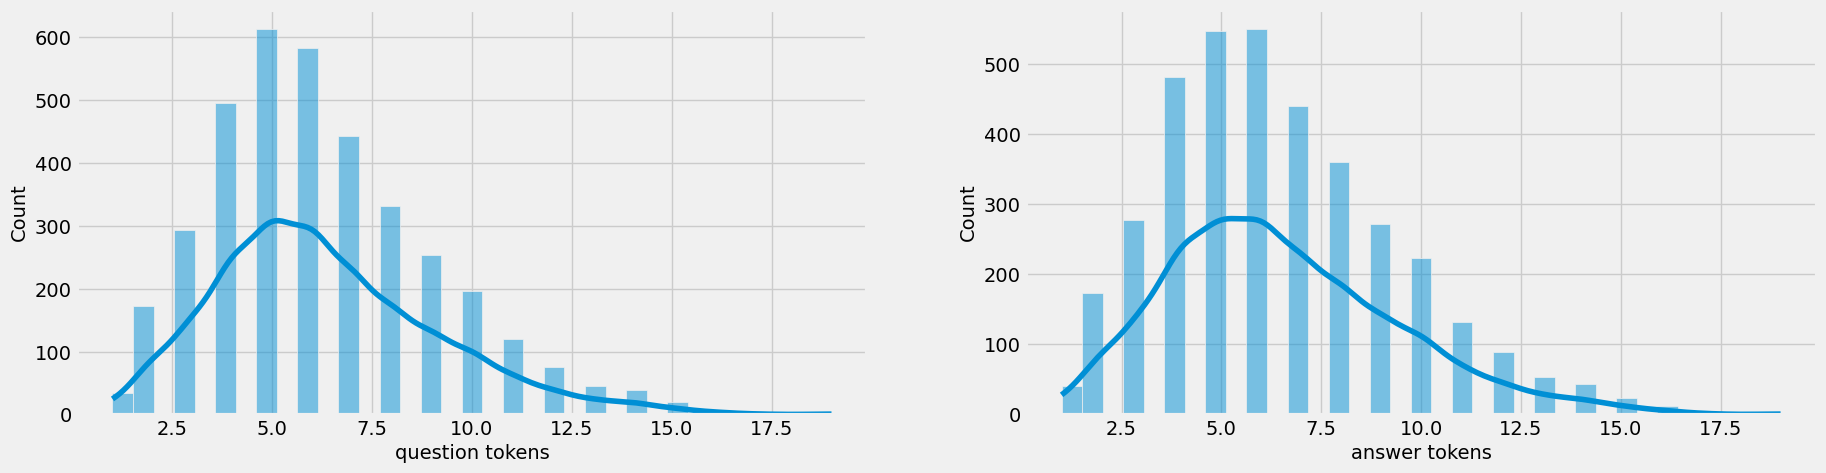

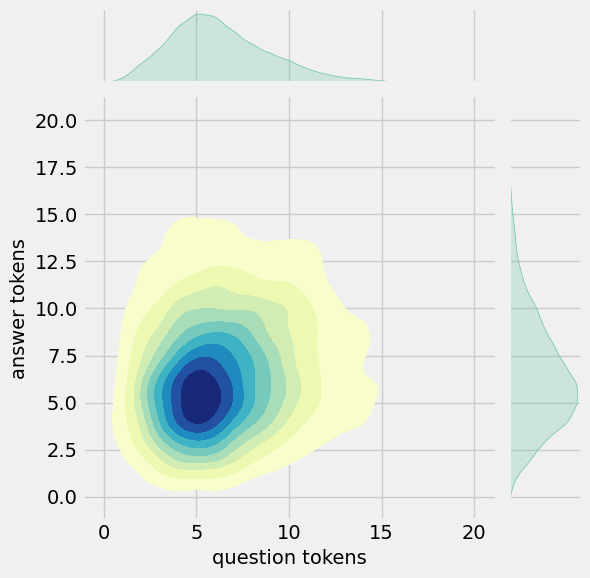

In [9]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['answer tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='answer tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [11]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


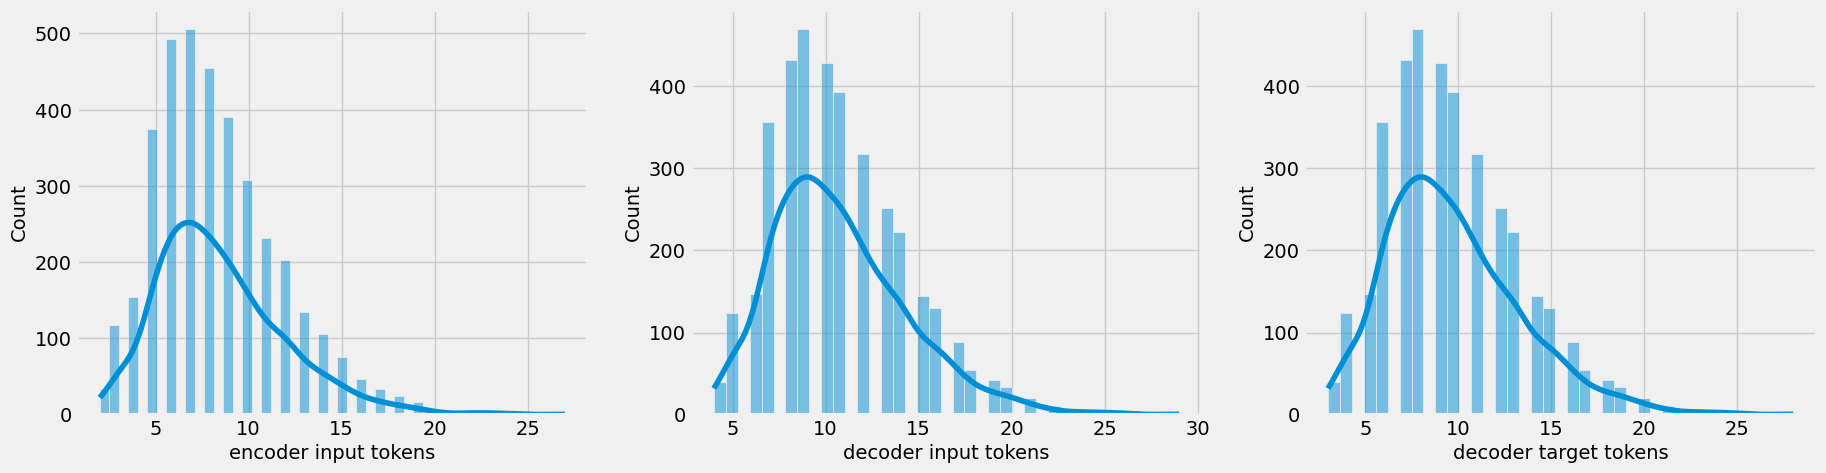

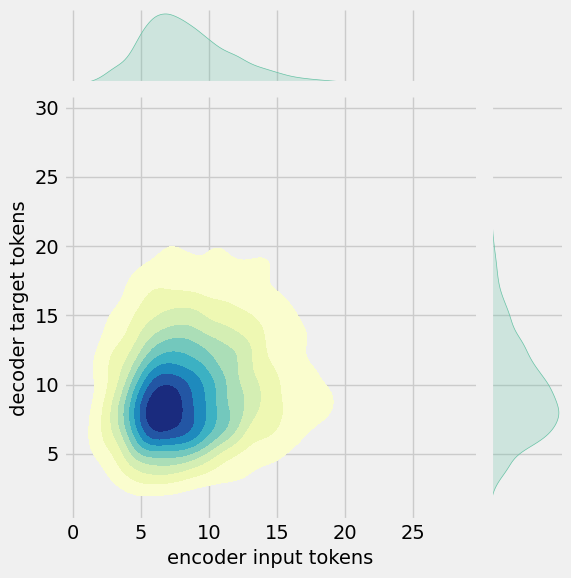

In [12]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [13]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [14]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [15]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [16]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [17]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


In [20]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.25657868,  0.02261904,  0.0352215 , ..., -0.03583265,
         -0.29141364, -0.0819687 ],
        [-0.13507074, -0.00058427,  0.0327164 , ..., -0.19281809,
         -0.10666002, -0.15878539],
        [ 0.04965711, -0.15347956, -0.10140225, ..., -0.10519869,
         -0.19297592, -0.22043376],
        ...,
        [-0.00577984,  0.05519179, -0.07643393, ..., -0.09434412,
         -0.08339826, -0.19268894],
        [-0.03506935, -0.09337728,  0.05089034, ...,  0.05473444,
         -0.02237174, -0.19478057],
        [ 0.2643577 ,  0.14948787,  0.03776374, ...,  0.07571603,
         -0.28151762, -0.09161043]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.4641112 ,  0.03874724,  0.08470367, ..., -0.06547393,
         -0.65103906, -0.1495778 ],
        [-0.34793186, -0.00133644,  0.05645338, ..., -0.41772857,
         -0.2623273 , -0.30730575],
        [ 0.12049466, -0.3658173 , -0.1639726 ,

In [21]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[1.4361454e-04, 3.5267201e-04, 1.4606693e-04, ...,
         1.8310408e-05, 3.9696723e-05, 8.2693068e-06],
        [3.4434133e-04, 1.6957513e-04, 5.6113622e-05, ...,
         6.7776607e-05, 1.9389594e-05, 4.2931402e-05],
        [1.5651518e-04, 8.3985324e-05, 4.9495025e-05, ...,
         2.1050023e-04, 1.9907204e-05, 2.9157833e-05],
        ...,
        [1.3656096e-03, 1.3009516e-04, 1.5287109e-04, ...,
         1.4747550e-04, 1.9776593e-05, 6.3473861e-05],
        [1.3656096e-03, 1.3009516e-04, 1.5287109e-04, ...,
         1.4747550e-04, 1.9776593e-05, 6.3473832e-05],
        [1.3656096e-03, 1.3009516e-04, 1.5287109e-04, ...,
         1.4747550e-04, 1.9776593e-05, 6.3473824e-05]]], dtype=float32)>

In [22]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total
    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    

In [23]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[1.43614467e-04, 3.52671952e-04, 1.46066915e-04, ...,
         1.83103984e-05, 3.96967371e-05, 8.26932501e-06],
        [3.44340835e-04, 1.69575214e-04, 5.61136767e-05, ...,
         6.77766075e-05, 1.93896140e-05, 4.29314059e-05],
        [1.56515118e-04, 8.39854183e-05, 4.94950073e-05, ...,
         2.10500351e-04, 1.99071965e-05, 2.91578217e-05],
        ...,
        [1.36560958e-03, 1.30095199e-04, 1.52871056e-04, ...,
         1.47475308e-04, 1.97766258e-05, 6.34737880e-05],
        [1.36560958e-03, 1.30095199e-04, 1.52871056e-04, ...,
         1.47475308e-04, 1.97766276e-05, 6.34737880e-05],
        [1.36560958e-03, 1.30095199e-04, 1.52871056e-04, ...,
         1.47475308e-04, 1.97766258e-05, 6.34737880e-05]],

       [[6.96682764e-05, 5.90308046e-05, 2.87577015e-04, ...,
         1.22820973e-04, 1.63300065e-04, 6.01662441e-06],
        [3.92316506e-05, 8.39343818e-04, 3.32069496e-04, ...,
         4.69278282e-04, 6

In [25]:
history=model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.2426 - accuracy: 0.3109
Epoch 1: val_loss improved from inf to 1.00114, saving model to ckpt
INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 36s 2s/step - loss: 1.2455 - accuracy: 0.3111 - val_loss: 1.0011 - val_accuracy: 0.3481
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.1084 - accuracy: 0.3381
Epoch 2: val_loss did not improve from 1.00114
23/23 [==============================] - 20s 875ms/step - loss: 1.1081 - accuracy: 0.3381 - val_loss: 1.0724 - val_accuracy: 0.3329
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.3570
Epoch 3: val_loss improved from 1.00114 to 0.97690, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 38s 2s/step - loss: 1.0213 - accuracy: 0.3578 - val_loss: 0.9769 - val_accuracy: 0.3870
Epoch 4/25
23/23 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.3676
Epoch 4: val_loss improved from 0.97690 to 0.95536, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 37s 2s/step - loss: 0.9629 - accuracy: 0.3678 - val_loss: 0.9554 - val_accuracy: 0.3758
Epoch 5/25
23/23 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 0.3782
Epoch 5: val_loss improved from 0.95536 to 0.88920, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 35s 2s/step - loss: 0.9286 - accuracy: 0.3779 - val_loss: 0.8892 - val_accuracy: 0.3956
Epoch 6/25
23/23 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.3890
Epoch 6: val_loss improved from 0.88920 to 0.86939, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 34s 2s/step - loss: 0.8795 - accuracy: 0.3898 - val_loss: 0.8694 - val_accuracy: 0.3824
Epoch 7/25
23/23 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.3979
Epoch 7: val_loss did not improve from 0.86939
23/23 [==============================] - 25s 1s/step - loss: 0.8579 - accuracy: 0.3960 - val_loss: 0.8728 - val_accuracy: 0.3651
Epoch 8/25
23/23 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.4094
Epoch 8: val_loss improved from 0.86939 to 0.83859, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 38s 2s/step - loss: 0.8243 - accuracy: 0.4085 - val_loss: 0.8386 - val_accuracy: 0.3910
Epoch 9/25
23/23 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.4181
Epoch 9: val_loss improved from 0.83859 to 0.76804, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 37s 2s/step - loss: 0.7978 - accuracy: 0.4180 - val_loss: 0.7680 - val_accuracy: 0.4364
Epoch 10/25
23/23 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.4237
Epoch 10: val_loss did not improve from 0.76804
23/23 [==============================] - 21s 909ms/step - loss: 0.7756 - accuracy: 0.4224 - val_loss: 0.8977 - val_accuracy: 0.3874
Epoch 11/25
23/23 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.4339
Epoch 11: val_loss improved from 0.76804 to 0.70819, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 36s 2s/step - loss: 0.7512 - accuracy: 0.4331 - val_loss: 0.7082 - val_accuracy: 0.4534
Epoch 12/25
23/23 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.4411
Epoch 12: val_loss did not improve from 0.70819
23/23 [==============================] - 21s 913ms/step - loss: 0.7352 - accuracy: 0.4409 - val_loss: 0.7857 - val_accuracy: 0.4486
Epoch 13/25
23/23 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.4523
Epoch 13: val_loss improved from 0.70819 to 0.69843, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 36s 2s/step - loss: 0.7138 - accuracy: 0.4517 - val_loss: 0.6984 - val_accuracy: 0.4960
Epoch 14/25
23/23 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.4591
Epoch 14: val_loss improved from 0.69843 to 0.69302, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 35s 2s/step - loss: 0.7014 - accuracy: 0.4581 - val_loss: 0.6930 - val_accuracy: 0.4427
Epoch 15/25
23/23 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.4616
Epoch 15: val_loss improved from 0.69302 to 0.68808, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 37s 2s/step - loss: 0.6827 - accuracy: 0.4621 - val_loss: 0.6881 - val_accuracy: 0.4454
Epoch 16/25
23/23 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.4683
Epoch 16: val_loss improved from 0.68808 to 0.62430, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 37s 2s/step - loss: 0.6673 - accuracy: 0.4677 - val_loss: 0.6243 - val_accuracy: 0.5043
Epoch 17/25
23/23 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.4738
Epoch 17: val_loss did not improve from 0.62430
23/23 [==============================] - 24s 1s/step - loss: 0.6576 - accuracy: 0.4723 - val_loss: 0.7417 - val_accuracy: 0.4700
Epoch 18/25
23/23 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.4784
Epoch 18: val_loss did not improve from 0.62430
23/23 [==============================] - 25s 1s/step - loss: 0.6448 - accuracy: 0.4773 - val_loss: 0.7684 - val_accuracy: 0.4664
Epoch 19/25
23/23 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.4849
Epoch 19: val_loss did not improve from 0.62430
23/23 [==============================] - 25s 1s/step - loss: 0.6351 - accuracy: 0.4853 - val_loss: 0.6813 - val_accuracy: 0.5054
Epoch 20/25
23/23 [==============================] - ET

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 36s 2s/step - loss: 0.6208 - accuracy: 0.4922 - val_loss: 0.6026 - val_accuracy: 0.5306
Epoch 21/25
23/23 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.4993
Epoch 21: val_loss did not improve from 0.60258
23/23 [==============================] - 24s 1s/step - loss: 0.6174 - accuracy: 0.4979 - val_loss: 0.6362 - val_accuracy: 0.5100
Epoch 22/25
23/23 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.5054
Epoch 22: val_loss improved from 0.60258 to 0.57315, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 36s 2s/step - loss: 0.5987 - accuracy: 0.5045 - val_loss: 0.5732 - val_accuracy: 0.5109
Epoch 23/25
23/23 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.5139
Epoch 23: val_loss did not improve from 0.57315
23/23 [==============================] - 25s 1s/step - loss: 0.5881 - accuracy: 0.5140 - val_loss: 0.5856 - val_accuracy: 0.5201
Epoch 24/25
23/23 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.5172
Epoch 24: val_loss did not improve from 0.57315
23/23 [==============================] - 26s 1s/step - loss: 0.5794 - accuracy: 0.5184 - val_loss: 0.5957 - val_accuracy: 0.5175
Epoch 25/25
23/23 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.5174
Epoch 25: val_loss did not improve from 0.57315
23/23 [==============================] - 26s 1s/step - loss: 0.5741 - accuracy: 0.5173 - val_loss: 0.6918 - val_accuracy: 0.5061


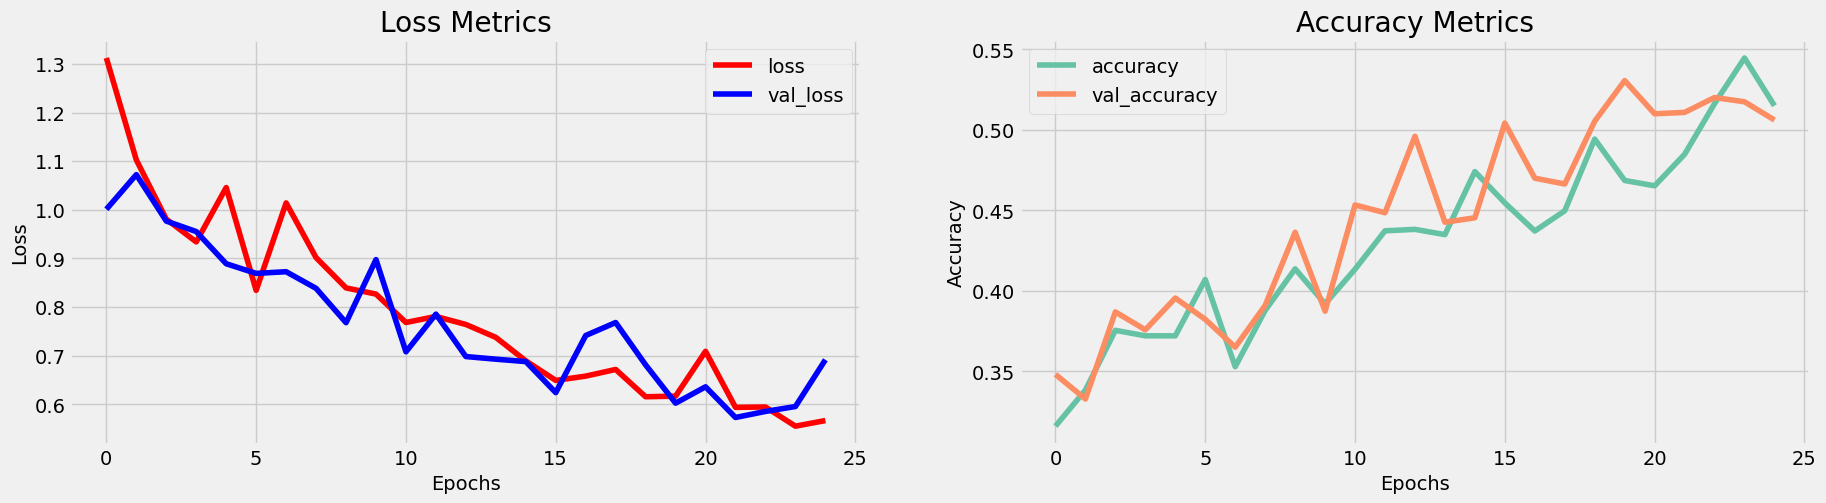

In [26]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()


In [27]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [29]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('************************')

Encoder layers:
************************
Decoder layers: 
************************


In [34]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder
    
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         625408    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1151232 (4.39 MB)
Trainable params: 1

In [35]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [36]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi
Bot: i have to go. 
You: do yo know me?
Bot: i like to see a movie this weekend. 
You: what is your name?
Bot: it was hoping the huge is nice. 
You: you are bot?
Bot: no, i don't want to go to the movies. 
You: hi, how are you doing?
Bot: i'm having a party this friday. 
You: i'm pretty good. thanks for asking.
Bot: you need a bath every day. 
You: Don't ever be in a hurry
Bot: it's the law. 
You: I'm gonna put some dirt in your eye 
Bot: are you sure? 
You: You're trash 
Bot: i don't think i'm going to be buried. 
You: I've read all your research on nano-technology 
Bot: of course. 
You: You want forgiveness? Get religion
Bot: sort of a little salt. 
You: While you're using the bathroom, i'll order some food.
Bot: i think i'll say. 
You: Wow! that's terrible.
Bot: don't you have to see. 
You: We'll be here forever.
Bot: i think it's the best job i'll just call you the bathroom. 
You: I need something that's reliable.
Bot: it was a great job. 
You: A speeding car ran a red ligh